In [1]:
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

In [2]:
LABEL_PATH = './data/classes.xlsx'
IMAGE_PATH = './data/'
IMAGE_SIZE = 224

df = pd.read_excel(LABEL_PATH)

df.columns = ['num', 'tirads']

df['cross'] = IMAGE_PATH + \
    df['num'].astype(str).values + \
    "/" + df['num'].astype(str).values + "_TIRADS" + df['tirads'].astype(str).values + "_cross.tif"

df['long'] = IMAGE_PATH + \
    df['num'].astype(str).values + \
    "/" + df['num'].astype(str).values + "_TIRADS" + df['tirads'].astype(str).values + "_long.tif"

# Удаляем несуществующие данные
for n in [178, 360, 363, 365, 366, 202, 346]:
    df.drop(index=df[df['num'] == n].index, inplace=True)

# Определим таргет для бинарной классификации
df['target'] = (df['tirads'] == 5).astype(int)

In [3]:
df.head()

,num,tirads,cross,long,target
1,179,5,./data/179/179_TIRADS5_cross.tif,./data/179/179_TIRADS5_long.tif,1
2,180,3,./data/180/180_TIRADS3_cross.tif,./data/180/180_TIRADS3_long.tif,0
3,181,5,./data/181/181_TIRADS5_cross.tif,./data/181/181_TIRADS5_long.tif,1
4,182,3,./data/182/182_TIRADS3_cross.tif,./data/182/182_TIRADS3_long.tif,0
5,183,5,./data/183/183_TIRADS5_cross.tif,./data/183/183_TIRADS5_long.tif,1


In [4]:
df['target'].value_counts()

0    21
1    20
Name: target, dtype: int64

In [5]:
# Добавим аугментацию к тренировочному датасету
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
class TiradDataset:

    def __init__(self, image_paths, targets, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert("RGB")
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.image_paths) 

In [35]:
cross_images = df['cross'].values
long_images = df['long'].values
targets = df['target'].values

train_X, val_X, train_y, val_y = train_test_split(
    long_images, targets, train_size=0.9, random_state=777, shuffle=True
)

train_dataset = TiradDataset(
    image_paths=train_X, 
    targets=train_y, 
    transform=train_transform
)

val_dataset = TiradDataset(
    image_paths=val_X, 
    targets=val_y, 
    transform=val_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    num_workers=4,
)

len(train_dataset), len(val_dataset)

(36, 5)

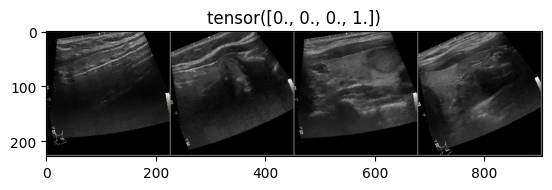

In [36]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=classes)

In [37]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [38]:
# Выходной слой классификации
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(512,120)
        self.fc2 = nn.Linear(120,2)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [92]:
model =  models.resnet18(pretrained=True).to(device)

model.fc = Classifier().to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [93]:
for param in model.parameters():
        param.requires_grad = False
for param in model.fc.parameters():
        param.requires_grad = True

In [94]:
# Лосс и оптимизатор

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [95]:
# Обучение

def train(model, criterion, optimizer, train_loader, val_loader, exp_lr_scheduler=None):
    train_loss = []
    val_loss = []
    
    train_acc = []
    val_acc = []

    epochs = 24

    for epoch in range(epochs):
        print("epoch {}/{}".format(epoch+1,epochs))
        running_loss = 0.0
        running_score = 0.0

        for image,label in train_loader:
            image = image.to(device)
            label = label.type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            y_pred = model.forward(image)
            loss = criterion(y_pred,label)         
            loss.backward() #calculate derivatives 
            optimizer.step() # update parameters
            val, index_ = torch.max(y_pred,axis=1)
            running_score += torch.sum(index_ == label.data).item()
            running_loss += loss.item()

        epoch_score = running_score/len(train_loader.dataset)
        epoch_loss = running_loss/len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_score)
        print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))

        if  exp_lr_scheduler:
            exp_lr_scheduler.step()

        with torch.no_grad():
            model.eval()
            running_loss = 0.0
            running_score = 0.0
            for image,label in val_loader:
                image = image.to(device)
                label = label.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                y_pred = model.forward(image)
                loss = criterion(y_pred,label)
                running_loss += loss.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()

            epoch_score = running_score/len(val_loader.dataset)
            epoch_loss = running_loss/len(val_loader.dataset)
            val_loss.append(epoch_loss)
            val_acc.append(epoch_score)
            print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
            
    return model, train_loss, val_loss, train_acc, val_acc

In [96]:
model, train_loss, val_loss, train_acc, val_acc = train(
    model, criterion, optimizer, train_loader, val_loader, exp_lr_scheduler
)

epoch 1/24
Training loss: 0.7874786108732224, accuracy: 0.3611111111111111
Validation loss: 0.24842460155487062, accuracy: 0.6
epoch 2/24
Training loss: 0.3853792647520701, accuracy: 0.4444444444444444
Validation loss: 0.4815326690673828, accuracy: 0.4
epoch 3/24
Training loss: 0.2207366575797399, accuracy: 0.5833333333333334
Validation loss: 0.23601973056793213, accuracy: 0.6
epoch 4/24
Training loss: 0.21068337559700012, accuracy: 0.4444444444444444
Validation loss: 0.3683188557624817, accuracy: 0.4
epoch 5/24
Training loss: 0.18631751504209307, accuracy: 0.4722222222222222
Validation loss: 0.23055303692817689, accuracy: 0.6
epoch 6/24
Training loss: 0.1756358096996943, accuracy: 0.5
Validation loss: 0.2523255467414856, accuracy: 0.6
epoch 7/24
Training loss: 0.17866393592622545, accuracy: 0.3888888888888889
Validation loss: 0.2701582074165344, accuracy: 1.0
epoch 8/24
Training loss: 0.17235142489274344, accuracy: 0.5555555555555556
Validation loss: 0.2697015643119812, accuracy: 1.0


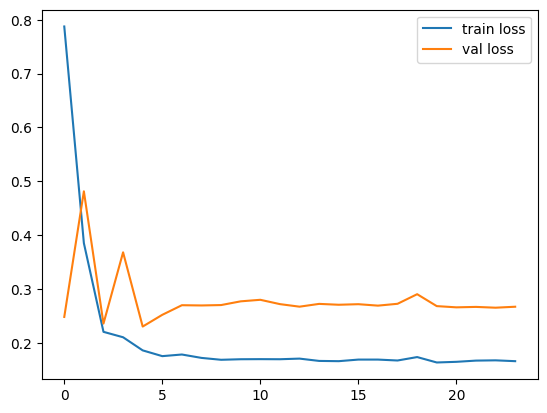

In [97]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='val loss')
plt.legend()
plt.show()

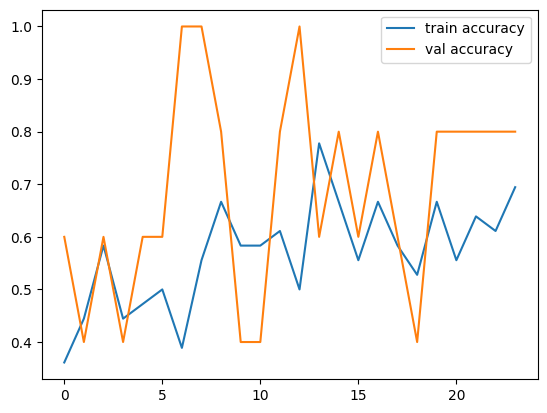

In [98]:
plt.plot(train_acc,label='train accuracy')
plt.plot(val_acc,label='val accuracy')
plt.legend()
plt.show()

### Посмотрим, что будет  с моделью для поперечных картинок

In [99]:
train_X, val_X, train_y, val_y = train_test_split(
    cross_images, targets, train_size=0.9, random_state=777, shuffle=True
)

train_dataset = TiradDataset(
    image_paths=train_X, 
    targets=train_y, 
    transform=train_transform
)

val_dataset = TiradDataset(
    image_paths=val_X, 
    targets=val_y, 
    transform=val_transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    num_workers=4,
)

len(train_dataset), len(val_dataset)

(36, 5)

In [100]:
model_cross =  models.resnet18(pretrained=True).to(device)

model_cross.fc = Classifier().to(device)

/home/era/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/era/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [101]:
for param in model_cross.parameters():
        param.requires_grad = False
for param in model_cross.fc.parameters():
        param.requires_grad = True
        
# Лосс и оптимизатор

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cross.parameters(), lr=0.01)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [102]:
model_cross, train_loss, val_loss, train_acc, val_acc = train(
    model_cross, criterion, optimizer, train_loader, val_loader, exp_lr_scheduler
)

epoch 1/24
Training loss: 0.45461061431301963, accuracy: 0.5
Validation loss: 0.2696269154548645, accuracy: 0.6
epoch 2/24
Training loss: 0.22462438543637595, accuracy: 0.4722222222222222
Validation loss: 0.3524322032928467, accuracy: 0.4
epoch 3/24
Training loss: 0.17377252711190116, accuracy: 0.6111111111111112
Validation loss: 0.2804721236228943, accuracy: 0.6
epoch 4/24
Training loss: 0.1823015825615989, accuracy: 0.3611111111111111
Validation loss: 0.32607672214508054, accuracy: 0.4
epoch 5/24
Training loss: 0.1882212973303265, accuracy: 0.5
Validation loss: 0.28749220371246337, accuracy: 0.4
epoch 6/24
Training loss: 0.18035699923833212, accuracy: 0.4722222222222222
Validation loss: 0.26046645641326904, accuracy: 0.6
epoch 7/24
Training loss: 0.1714530752764808, accuracy: 0.5277777777777778
Validation loss: 0.2824313521385193, accuracy: 0.4
epoch 8/24
Training loss: 0.17081819143560198, accuracy: 0.5277777777777778
Validation loss: 0.28988187313079833, accuracy: 0.4
epoch 9/24
Tr

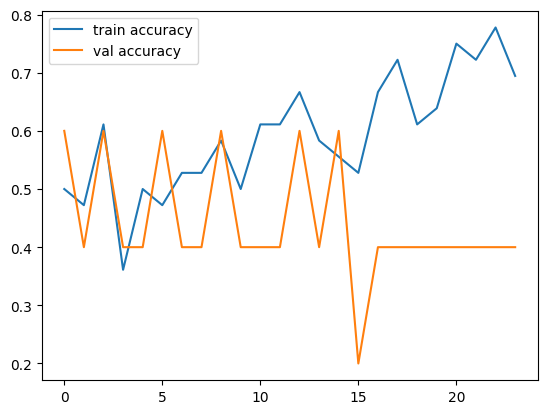

In [103]:
plt.plot(train_acc,label='train accuracy')
plt.plot(val_acc,label='val accuracy')
plt.legend()
plt.show()

### Возможно tirad == 5 не очень видны с поперечных снимков